<a href="https://colab.research.google.com/github/azizdhaoui/Gaussian-Mixture-Models/blob/main/Gaussian_Mixture_Models_for_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

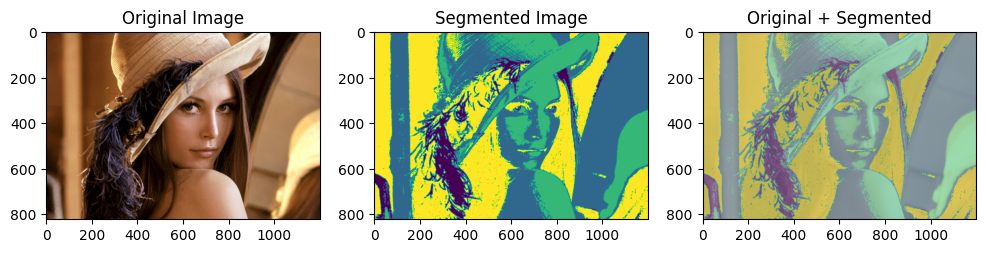

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.special import logsumexp

def initialize_parameters(data, num_clusters):
    # Randomly initialize parameters: mean, covariance, and mixing coefficients
    num_samples, _ = data.shape
    indices = np.random.choice(num_samples, num_clusters, replace=False)
    means = data[indices, :]
    covariances = [np.eye(data.shape[1]) for _ in range(num_clusters)]
    weights = np.ones(num_clusters) / num_clusters

    return means, covariances, weights

def gaussian_pdf(x, mean, covariance):
    d = x.shape[0]
    det_cov = np.linalg.det(covariance)
    inv_cov = np.linalg.inv(covariance)
    exponent = -0.5 * np.sum(np.dot((x - mean), inv_cov) * (x - mean), axis=1)
    log_coefficient = -0.5 * (d * np.log(2 * np.pi) + np.log(det_cov))
    log_likelihood = log_coefficient + exponent
    return log_likelihood

def expectation_step(data, means, covariances, weights):
    num_clusters = len(means)
    num_samples = data.shape[0]
    responsibilities = np.zeros((num_samples, num_clusters))

    for i in range(num_clusters):
        responsibilities[:, i] = np.log(weights[i]) + gaussian_pdf(data, means[i], covariances[i])

    log_sum_responsibilities = logsumexp(responsibilities, axis=1, keepdims=True)
    responsibilities = np.exp(responsibilities - log_sum_responsibilities)

    return responsibilities

def maximization_step(data, responsibilities):
    num_clusters = responsibilities.shape[1]
    num_samples, _ = data.shape

    # Update mean
    means = np.dot(responsibilities.T, data) / np.sum(responsibilities, axis=0, keepdims=True).T

    # Update covariance
    covariances = []
    for i in range(num_clusters):
        diff = data - means[i]
        cov_i = np.dot((responsibilities[:, i] * diff.T), diff) / np.sum(responsibilities[:, i])
        covariances.append(cov_i)

    # Update weights
    weights = np.sum(responsibilities, axis=0) / num_samples

    return means, covariances, weights

def gmm_em(data, num_clusters, num_iterations):
    means, covariances, weights = initialize_parameters(data, num_clusters)

    for _ in range(num_iterations):
        # Expectation step
        responsibilities = expectation_step(data, means, covariances, weights)

        # Maximization step
        means, covariances, weights = maximization_step(data, responsibilities)

    return means, covariances, weights

def segment_image(image_path, num_clusters, num_iterations):
    # Load and flatten the image
    img = cv2.imread(image_path)
    data = img.reshape((-1, 3)).astype(np.float32)

    # Normalize the data
    data /= 255.0

    # Run EM algorithm
    means, covariances, weights = gmm_em(data, num_clusters, num_iterations)

    # Assign each pixel to the cluster with the highest responsibility
    responsibilities = expectation_step(data, means, covariances, weights)
    labels = np.argmax(responsibilities, axis=1)

    # Reshape the labels to the shape of the original image
    segmented_img = labels.reshape(img.shape[:2])

    # Post-processing: Apply Gaussian blur to the segmented image
    segmented_img = cv2.GaussianBlur(segmented_img.astype(np.float32), (5, 5), 0)

    # Display the original and segmented images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 3, 2)
    plt.title("Segmented Image")
    plt.imshow(segmented_img, cmap='viridis')
    plt.subplot(1, 3, 3)
    plt.title("Original + Segmented")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), alpha=0.5)
    plt.imshow(segmented_img, cmap='viridis', alpha=0.5)
    plt.show()


segment_image('lenna.jpg', num_clusters=4, num_iterations=111)